# Module 4
## Step 3: Sensitivity Analysis

For this section, we will refer primarily to methods indicated in Ligmann-Zielinska et al. (2020) (LZ 2020), Kwakkel (2017), and course materials.

As we mention in the previous section, the Altruism model is a more "abstract" model. Therefore, it seems that an appropriate route for sensitivity analysis (SA) would be to start with a One at A Time (OAT) SA, as recommended by Figure 3 in LZ 2020. Note that here we have selected a simpler OAT rather than an One Factor At a Time--we are stepping through all of the parameters at regular intevals (see in the ranges below) rather than using random intervals. We do this with the intent to better understand the model and choose a next analysis.



In [17]:
import os
import sys
import numpy as np
import pandas as pd

# Add the parent directory to the Python path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.pynetlogo_utils import run_altruism_experiment, process_results


base_altruism_model = "./M4Model_Dresslar_base.nlogo"  # (copied into this directory!)

max_ticks = 15000  # so expensive. many runs collapse right away, but if they do not we need to know why.

# important: run_altruism_experiment needs arrays even if we have single value params, which we do.
# keep the first two params at 0.26
altruistic_probability = [0.26]
selfish_probability = [0.26]

# four ranges, one for each sensitivity param
cost_range = np.linspace(0, 1.0, 5) # note that > 0.9 is OOB
benefit_range = np.linspace(0, 1.0, 5) # note that > 0.9 is OOB
disease_range = np.linspace(0, 1.0, 5) # inclusive of 1.0
harshness_range = np.linspace(0, 1.0, 5) # inclusive of 1.0
runs_per_node = 10

As requested in the assignment, we are exploring the (altruism) cost, (altruism) benefit, disease, and harshness parameters of the model. Our currency is the populations of "altruists" and "selfish" at the completion of the model. We might note that a specific model behavior is the collapse and extinction of one of the populations at a certain point, and that the duration of resilience of one group or the other that becomes extinct might be a useful secondary measure: for instance, we might class a run in which the altruists reach zero population in 20 ticks to be different from a run in which they do so at tick 2000. 

So, for our OAT testing, weʻll attempt to explore that factor just to understand the parameter settings at which lengthy meaningful runs are possible. To do this, our model is modified to stop on the tick when either altruists of selfish reach zero population, and we set up a very large maximum ticks value in order to account for long (within practical reason) duration runs. At certain starting parameters, the model can stay quite dynamic, with both populations swapping positions of advantgae multiple times, even for thousands of ticks.

Our runs are set up again using `pynetlogo`, this time working with a separate module that contains the running code for convenience. The experimental harness code has changed very little from our previous notebook and the M2 module assignment, with the exception that it has been designed to be possible to stop and start from a checkpoint.

The `pynetlogo` code will sweep the designated parameters listed in the codeblock above. Note that `altuistic_probability` and `selfish_probability` are left at their defaults. 

As for `runs_per_node`, first it should be explained that we call a multi-paramater settings point on our 4x5 matrix (formed using the ranges) a "multi-parameter node" or "node." Since this is an exploration the decision has been made to simply always perform as many runs as practically possible given time constraints. 10 runs per "node" seem sufficient, and we will mark in our analysis parameter settings for which there were multiple "outcomes" within the nodes.

In [18]:
# conservatively run a first pass to see if we can find breakpoints. similar to our searching in M2.

# results_first_search_filename = run_altruism_experiment(base_altruism_model, 
                                            #  "first_search", 
                                            #  max_ticks,
                                            #  runs_per_node,
                                            #  altruistic_probability, 
                                            #  selfish_probability, 
                                            #  cost_range, 
                                            #  benefit_range,
                                            #  disease_range,
                                            #  harshness_range)


Once this has been completed, we have a CSV file with results for each run for each node. The header and first twelve rows look like:

In [19]:
df = pd.read_csv("first_search_results.csv")
df.head(12)
# or, df.tail()

,altruistic_probability,selfish_probability,cost_of_altruism,benefit_from_altruism,disease,harshness,run_number,ticks,altruists,selfish,void,max_pink,max_green,max_black
0,0.26,0.26,0.0,0.0,0.0,0.00,0,1062.0,0.0,1681.0,0.0,825.0,1681.0,39.0
1,0.26,0.26,0.0,0.0,0.0,0.00,1,5631.0,1681.0,0.0,0.0,1681.0,1234.0,50.0
2,0.26,0.26,0.0,0.0,0.0,0.00,2,2669.0,1681.0,0.0,0.0,1681.0,876.0,33.0
3,0.26,0.26,0.0,0.0,0.0,0.00,3,800.0,1681.0,0.0,0.0,1681.0,901.0,45.0
4,0.26,0.26,0.0,0.0,0.0,0.00,4,3170.0,1681.0,0.0,0.0,1681.0,831.0,40.0
5,0.26,0.26,0.0,0.0,0.0,0.00,5,5225.0,0.0,1681.0,0.0,805.0,1681.0,42.0
6,0.26,0.26,0.0,0.0,0.0,0.00,6,2931.0,0.0,1681.0,0.0,1243.0,1681.0,44.0
7,0.26,0.26,0.0,0.0,0.0,0.00,7,15000.0,1124.0,557.0,0.0,1499.0,1626.0,37.0
8,0.26,0.26,0.0,0.0,0.0,0.00,8,2383.0,0.0,1681.0,0.0,935.0,1681.0,45.0
9,0.26,0.26,0.0,0.0,0.0,0.00,9,6573.0,0.0,1681.0,0.0,1052.0,1681.0,42.0


As we can see from our data, harshness is adjusted starting on data row 10. Ticks numbers are very high in this tiny sample of parameters, it might be noted; starting the simulation with "all zeros" does indeed lead to some very long and unpredictable runs. The vast majority of the parameter nodes sampled collapse far sooner, frequently well within 100 ticks. In order to use our data to perform analyses, it seems useful to summarize the runs into means and standard deviations, which we will do here:

In [20]:
results_first_search_filename = "first_search_results.csv"

first_search_stats_filename = process_results(results_first_search_filename, runs_per_node, max_ticks)

Interesting results for node 0: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.0
Interesting results for node 1: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.25
Interesting results for node 2: ['variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.5
Interesting results for node 3: ['variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.75
Interesting results for node 4: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 1.0
Interesting results for node 5: ['variable altruists_died_outcomes'

We now have available a file with all our mean and standard deviations for each measured output (currency) for each 10-run bundle for each "node" in our OAT matrix. Additionally, we have asked our results processor to also list any nodes that have "interesting" run spreads... basically, any major variance in the outcomes of one or more runs. As mentioned above, these are largely grouped at zero settings for `cost` and `benefit`... but there do appear to be some other breakpoints at which there is some non-determinism in outcomes. Further OAT or especially OFAT scans might center on those matrix locations.

Here is a snippet of the stats file. Weʻll order it randomly so we can preview ten random "nodes".

In [21]:
first_search_stats_filename = "first_search_results_statistics.csv"

df = pd.read_csv(first_search_stats_filename)
# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)
# or, df.tail()

,altruistic_probability,selfish_probability,cost_of_altruism,benefit_from_altruism,disease,harshness,ticks_mean,ticks_std,altruists_mean,altruists_std,selfish_mean,selfish_std,void_mean,void_std,max_pink_mean,max_pink_std,max_green_mean,max_green_std,max_black_mean,max_black_std
0,0.26,0.26,0.50,0.50,0.0,0.50,20.5,2.3,0.0,0.0,1680.7,0.7,0.3,0.7,443.2,34.4,1680.7,0.7,622.5,26.0
1,0.26,0.26,0.75,0.75,0.0,0.75,12.3,1.2,0.0,0.0,1496.6,48.3,184.4,48.3,310.0,23.3,1496.6,48.3,769.5,19.3
2,0.26,0.26,0.50,0.50,0.0,0.00,22.4,3.8,0.0,0.0,1681.0,0.0,0.0,0.0,718.0,31.9,1681.0,0.0,42.5,8.9
3,0.26,0.26,0.25,0.25,1.0,0.50,54.0,17.0,0.0,0.0,821.8,35.3,859.2,35.3,385.4,17.7,854.5,25.3,955.1,15.7
4,0.26,0.26,0.25,0.75,0.5,0.50,141.3,25.9,0.0,0.0,1277.3,11.7,403.7,11.7,573.9,53.6,1307.3,13.0,683.6,26.3
5,0.26,0.26,0.00,0.75,0.5,1.00,62.5,16.1,1265.0,38.8,0.0,0.0,416.0,38.8,1281.5,48.8,418.4,24.0,891.4,40.0
6,0.26,0.26,1.00,1.00,0.5,0.00,9.0,1.4,0.0,0.0,1507.7,12.2,173.3,12.2,383.3,30.2,1518.7,6.6,442.5,21.4
7,0.26,0.26,0.00,1.00,0.5,0.75,71.8,12.4,1505.2,11.8,0.0,0.0,175.8,11.8,1525.6,10.3,465.2,21.8,730.8,23.2
8,0.26,0.26,0.75,0.00,1.0,0.75,5.8,1.2,0.0,0.0,373.4,33.9,1307.6,33.9,140.8,9.8,471.7,11.5,1307.6,33.9
9,0.26,0.26,0.75,0.50,1.0,0.25,10.2,1.4,0.0,0.0,1146.6,19.7,534.4,19.7,288.4,12.2,1150.2,19.1,802.4,27.8


These data should now be ready, in particular our currency values "altruists_mean" and "selfish_mean", for analysis. We might use graphics to start. To do this, it should be possible to focus on two of the parameters at a time to create 3D plots. Since our altruists and selfish values are mostly reciprocal, we can simplify things by visualizing how parameters yield altruists_mean. We can use `cost_` vs `benefit_` for one of the plots, and `disease` vs. `harshness` for the other. For our plots, we will coalesce the relevant means into single node "steps" for each variable explored.

[[5.144840e+02 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [1.186116e+03 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [1.321104e+03 4.000000e-03 0.000000e+00 0.000000e+00 0.000000e+00]
 [1.429248e+03 4.030000e+01 0.000000e+00 0.000000e+00 0.000000e+00]
 [1.503928e+03 2.512400e+02 0.000000e+00 0.000000e+00 0.000000e+00]]
[[300.352 300.352 300.352 300.352 300.352 298.892 298.892 298.892 298.892
  298.892 287.784 287.784 287.784 287.784 287.784 269.996 269.996 269.996
  269.996 269.996 263.596 263.596 263.596 263.596 263.596]
 [300.352 300.352 300.352 300.352 300.352 298.892 298.892 298.892 298.892
  298.892 287.784 287.784 287.784 287.784 287.784 269.996 269.996 269.996
  269.996 269.996 263.596 263.596 263.596 263.596 263.596]
 [300.352 300.352 300.352 300.352 300.352 298.892 298.892 298.892 298.892
  298.892 287.784 287.784 287.784 287.784 287.784 269.996 269.996 269.996
  269.996 269.996 263.596 263.596 263.596 263.596 263.596]
 [300.352 300.352 300.352 300.352 300.

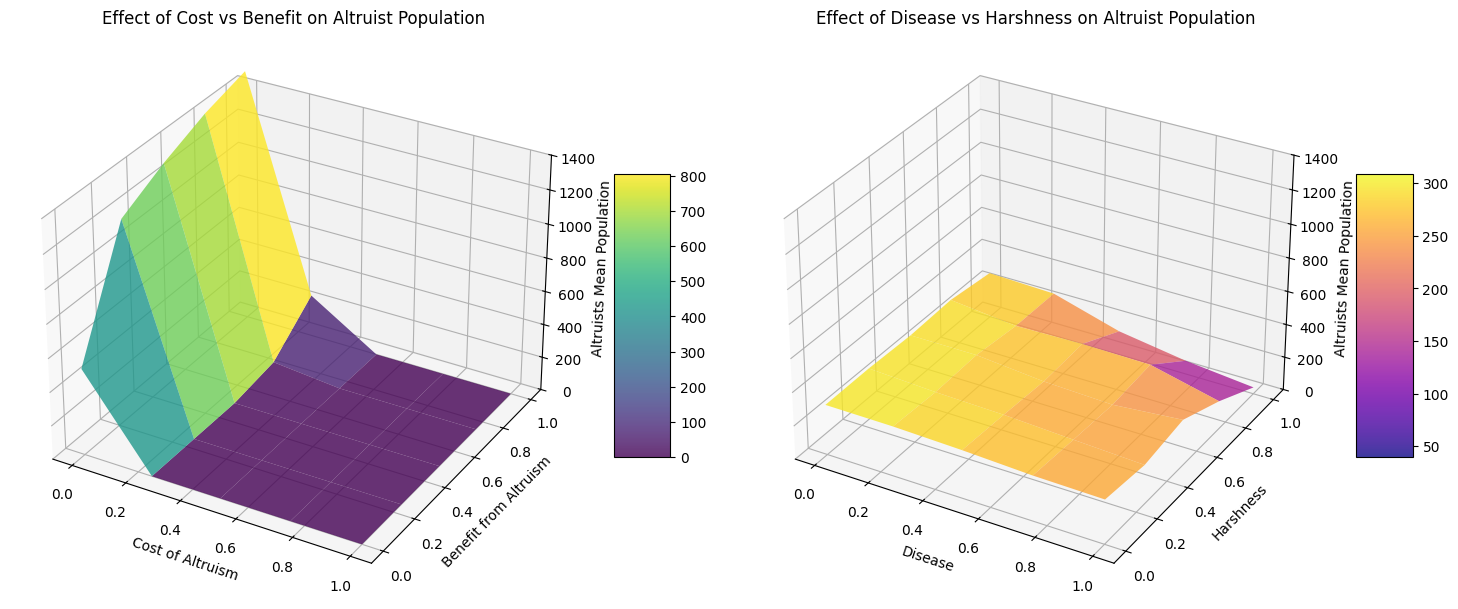

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# we already have these from above and can use them for plotting:
# Define the parameter ranges
cost_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
benefit_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
disease_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
harshness_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00


# as mentioned in the markdown above, we coalesce (or aggregate, really) the relevant means into single node "steps" for each variable explored.
cost_benefit_z_df = df.groupby(['cost_of_altruism', 'benefit_from_altruism']).aggregate(
    altruists_mean=('altruists_mean', 'mean')  # mean of means... this will be our Z values
).reset_index()

# now we can greate a grid for the surface of the plot
# see: https://aleksandarhaber.com/explanation-of-pythons-meshgrid-function-numpy-and-3d-plotting-in-python/
X1, Y1 = np.meshgrid(cost_range, benefit_range)  

# print the values of X1 and Y1
# print(X1)
# print(Y1)  # looks good!

Z1 = np.zeros_like(X1)
for i, cost in enumerate(cost_range):
    for j, benefit in enumerate(benefit_range):
        intersection = df[(df['cost_of_altruism'] == cost) & (df['benefit_from_altruism'] == benefit)]
        if not intersection.empty:
            Z1[j, i] = intersection['altruists_mean'].mean()


print(Z1)

# we have to use the exact same code (opposite params) for the other plot
disease_harshness_z_df = df.groupby(['disease', 'harshness']).aggregate(
    altruists_mean=('altruists_mean', 'mean')
).reset_index()

disease_values = sorted(disease_harshness_z_df['disease'])
harshness_values = sorted(disease_harshness_z_df['harshness'])
X2, Y2 = np.meshgrid(disease_values, harshness_values)

Z2 = np.zeros_like(X2)
for i, disease in enumerate(disease_values):
    for j, harshness in enumerate(harshness_values):
        intersection = df[(df['disease'] == disease) & (df['harshness'] == harshness)]
        if not intersection.empty:
            Z2[j, i] = intersection['altruists_mean'].mean()


print(Z2)



fig = plt.figure(figsize=(15, 6))

# "We create the plot by calling the function “plot_surface(X, Y, Z, cmap=”plasma”, linewidth=0, antialiased=False, alpha=0.5):"
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('Cost of Altruism')
ax1.set_ylabel('Benefit from Altruism')
ax1.set_zlabel('Altruists Mean Population')
ax1.set_zlim(0,1400)
ax1.set_title('Effect of Cost vs Benefit on Altruist Population')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Second plot: Disease vs Harshness
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, Z2, cmap='plasma', edgecolor='none', alpha=0.8)
ax2.set_xlabel('Disease')
ax2.set_ylabel('Harshness')
ax2.set_zlabel('Altruists Mean Population')
ax2.set_zlim(0,1400)
ax2.set_title('Effect of Disease vs Harshness on Altruist Population')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

LZ indicates that for an abstract model, a prudent next step after a graphical representation would be regresssion.

### Notes

### References

Kwakkel, J. H., & Jaxa-Rozen, M. (2017). Example 2: Sensitivity analysis for a NetLogo model with SALib and ipyparallel. pyNetLogo Documentation. https://pynetlogo.readthedocs.io/en/latest/docs/SALib_ipyparallel.html

Ligmann-Zielinska, A., Siebers, P. O., Magliocca, N., Parker, D. C., Grimm, V., Du, J., ... & Ye, X. (2020). ‘One size does not fit all’: A roadmap of purpose-driven mixed-method pathways for sensitivity analysis of agent-based models. Journal of Artificial Societies and Social Simulation, 23(1).